In [30]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2

In [ ]:
train_ds, val_ds, test_ds = tfds.load(
    'wider_face',
    split=['train', 'validation', 'test'],
    shuffle_files=True
)

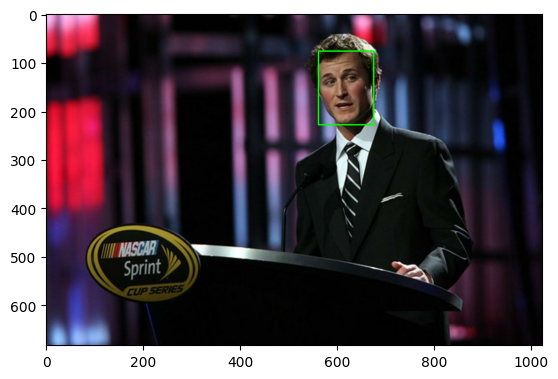

In [49]:
for sample in train_ds.take(1):
    h,w=sample['image'].shape[:2]
    img=sample['image'].numpy()
    for box in sample['faces']['bbox']:
        ymin, xmin, ymax, xmax = box
        x = int(xmin * w)
        y = int(ymin * h)
        box_w = int((xmax - xmin) * w)
        box_h = int((ymax - ymin) * h)
        cv2.rectangle(img, (x, y), (x + box_w, y + box_h), (0, 255, 0), 2)
    plt.imshow(img)
